<a href="https://colab.research.google.com/github/afifaniks/TomatoLeafDiseaseDetection/blob/master/Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp 'drive/My Drive/Leaf Disease/Dataset/Train_Dataset.zip' .

In [ ]:
!unzip Train_Dataset.zip

# Importing Modules

In [ ]:
!pip install extra_keras_metrics

In [ ]:
%tensorflow_version 1.15
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import keras
from keras.preprocessing import image
import numpy as np
import extra_keras_metrics as ekm
from keras.utils import plot_model
import json

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


# Data Preparation

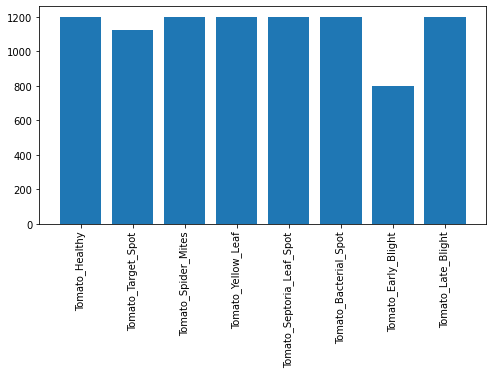

In [ ]:
data_folder = 'Data_3/Train'
directory = os.listdir(data_folder)

file_counts = {}
for d in directory:
    file_counts[d] = len(os.listdir(os.path.join(data_folder, d)))
    
# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(file_counts.keys(), file_counts.values())
plt.xticks(rotation='vertical')
plt.show()

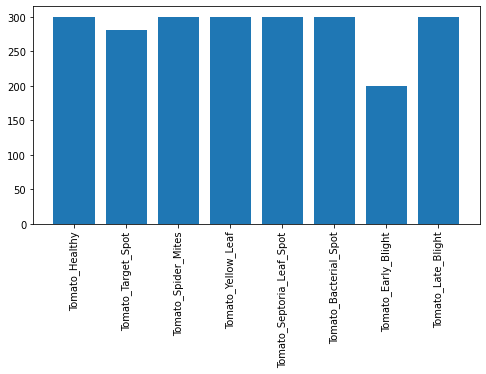

In [ ]:
data_folder = 'Data_3/Test'
directory = os.listdir(data_folder)

file_counts = {}
for d in directory:
    file_counts[d] = len(os.listdir(os.path.join(data_folder, d)))
    
# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(file_counts.keys(), file_counts.values())
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
image = plt.imread('Data_3/Train/Tomato_Bacterial_Spot/0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_Bact.Sp 6254.JPG')
image.shape

(256, 256, 3)

In [ ]:
# Image preprocessing
img_height = image.shape[0]
img_width = image.shape[1]

train_data_dir = 'Data_3/Train'
test_data_dir = 'Data_3/Test'

epochs = 50
batch_size = 20
batch_dim = -1

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
    batch_dim = 1
else:
    input_shape = (img_height, img_width, 3)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, rotation_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = train_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 9124 images belonging to 8 classes.
Found 2280 images belonging to 8 classes.


In [ ]:
train_size = len(train_generator.labels)
test_size = len(test_generator.labels)

# Model Preparation

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=batch_dim))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(Dropout(0.2))

model.add(Dense(8))
model.add(Activation(activation='softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
______________________________________

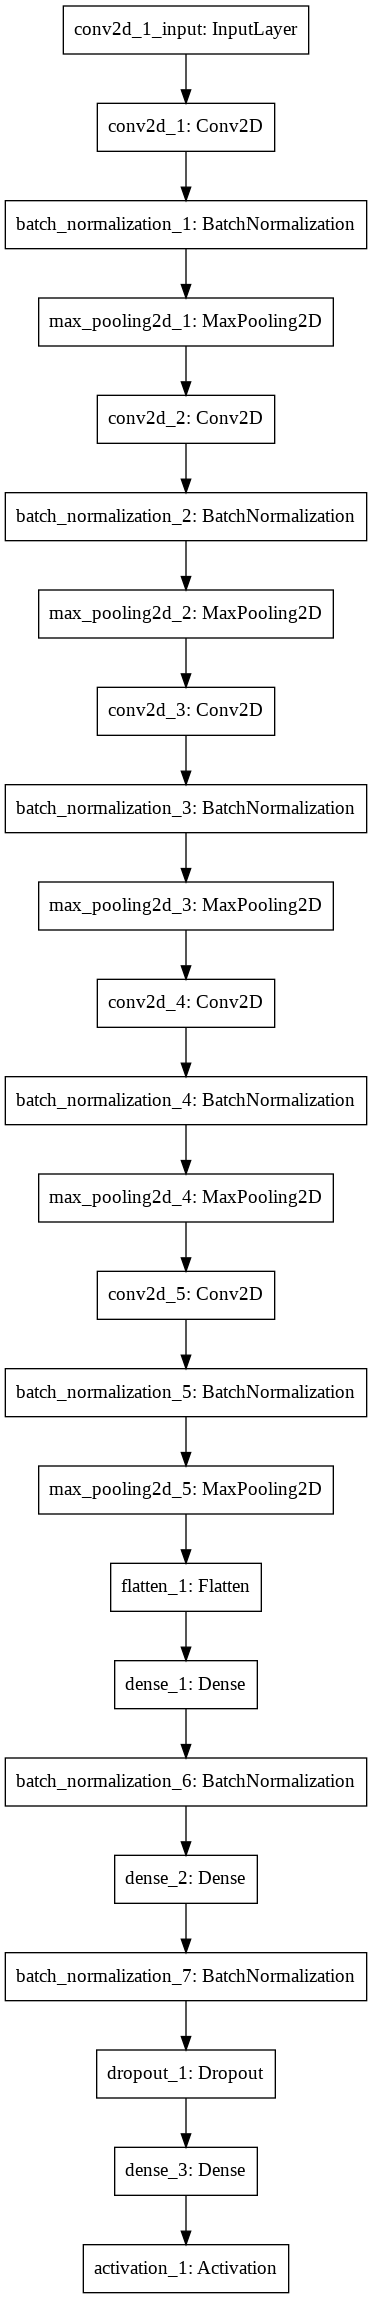

In [ ]:
plot_model(model, to_file='model.png')

In [ ]:
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('plants.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [15]:
metrics=["accuracy", ekm.precision, ekm.recall]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
results = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=np.ceil(train_size/batch_size), validation_data=test_generator, validation_steps=np.ceil(test_size/batch_size), callbacks=callbacks)


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50
457/457 [==============================] - 181s 397ms/step - loss: 0.7767 - accuracy: 0.7302 - precision: 0.7345 - recall: 0.5549 - val_loss: 3.5912 - val_accuracy: 0.3868 - val_precision: 0.7557 - val_recall: 0.6302

Epoch 00001: val_loss improved from inf to 3.59123, saving model to plants.h5
Epoch 2/50
457/457 [==============================] - 174s 380ms/step - loss: 0.4834 - accuracy: 0.8330 - precision: 0.7591 - recall: 0.6528 - val_loss: 0.2806 - val_accuracy: 0.8443 - val_precision: 0.7922 - val_recall: 0.6971

Epoch 00002: val_loss improved from 3.59123 to 0.28063, saving model to plants.h5
Epoch 3/50
457/457 [==============================] - 170s 373ms/step - loss: 0.3802 - accuracy: 0.8709 - precision: 0.8119 - recall: 0.7250 - val_loss: 0.8

# Observations

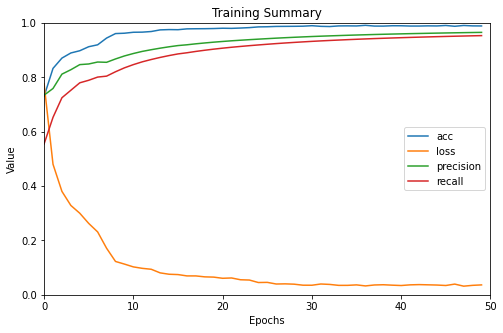

In [19]:
plt.figure(figsize=(8, 5))
plt.title("Training Summary")
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.plot(results.history['accuracy'], label="acc")
plt.plot(results.history['loss'], label="loss")
plt.plot(results.history['precision'], label="precision")
plt.plot(results.history['recall'], label="recall")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend();

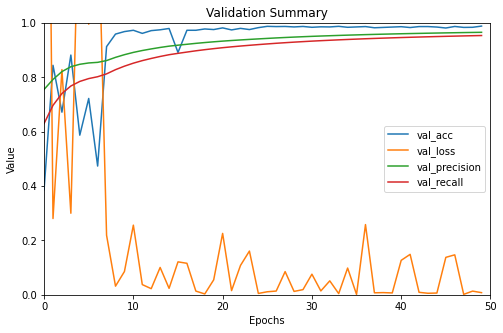

In [20]:
plt.figure(figsize=(8, 5))
plt.title("Validation Summary")
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.plot(results.history['val_accuracy'], label="val_acc")
plt.plot(results.history['val_loss'], label="val_loss")
plt.plot(results.history['val_precision'], label="val_precision")
plt.plot(results.history['val_recall'], label="val_recall")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend();

# Download History

In [ ]:
model_history = results.history

In [ ]:
with open("history.json", "w") as f:
    json.dump(str(model_history), f)
files.download("history.json")

In [ ]:
print("Good Job Anik! Trivial! Yet, nicely put!") #SNP